In [1]:
import os

import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader

In [2]:
from dotenv import load_dotenv

# 현재 작업 디렉토리 가져오기
current_dir = os.getcwd()  # 현재 Jupyter Notebook의 작업 디렉토
env_path = os.path.join(current_dir, '../.env')

# .env 파일 로드
load_dotenv(env_path)

True

In [3]:
db_path=os.getenv("DATA_PATH")
ecg_data=pd.read_csv(f'{db_path}/ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


## 모델 및 하이퍼파라미터 준비
BCResNet의 cnn_first의 stride나 다른 conv의 stride에 따라 입력 또는 출력의 크기가 달라짐.
이는 조절해가면서 실험필요

In [4]:
import numpy as np
from sklearn.metrics import roc_auc_score

In [5]:

from ver4_journal.common.network.BCResNets import BCResNets

tau = 1
in_channel = 12
model = BCResNets(int(tau * 8), 5, in_channel)

if in_channel == 1:
    sample = torch.randn(1,12,1000)
else:
    sample = torch.randn(1,12,1000)
    #sample = torch.randn(1,12,20,48)

print(sample.shape)
pred = model(sample)
pred.shape

torch.Size([1, 12, 1000])


torch.Size([1, 5])

Class 0 count in ECG_train: 9415
Class 1 count in ECG_train: 7596
Class weights: {0: np.float64(1.8067976633032394), 1: np.float64(2.239468141126909)}
Weight tensor: tensor([1.8068, 2.2395])
Batch shape: torch.Size([32, 12, 1000])
532 67 68
Using mps device
Epoch: 1/50, Training Loss: 1.0424, Training Accuracy: 0.55%
Test Loss: 1.0614, Test Accuracy: 0.55%
Macro AUC: 0.9047, 0.9047
Epoch: 2/50, Training Loss: 0.8353, Training Accuracy: 0.55%
Test Loss: 0.9085, Test Accuracy: 0.55%
Macro AUC: 0.9132, 0.9132
Epoch: 3/50, Training Loss: 0.7861, Training Accuracy: 0.55%
Test Loss: 0.9383, Test Accuracy: 0.55%
Macro AUC: 0.9126, 0.9126
Epoch: 4/50, Training Loss: 0.7706, Training Accuracy: 0.55%
Test Loss: 0.9065, Test Accuracy: 0.55%
Macro AUC: 0.9177, 0.9177
Epoch: 5/50, Training Loss: 0.7630, Training Accuracy: 0.55%
Test Loss: 0.9000, Test Accuracy: 0.55%
Macro AUC: 0.9164, 0.9164
Epoch: 6/50, Training Loss: 0.7462, Training Accuracy: 0.55%
Test Loss: 0.8406, Test Accuracy: 0.55%
Macro 

KeyboardInterrupt: 

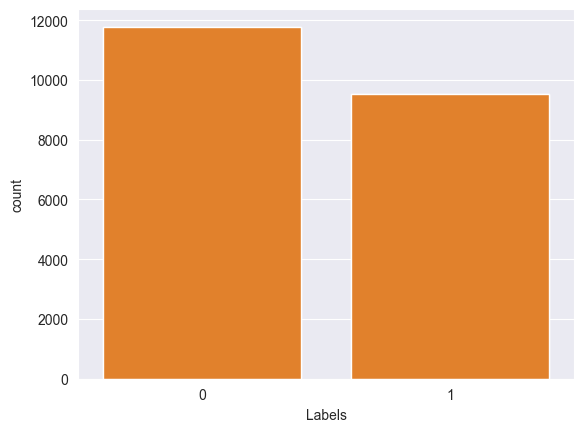

In [6]:
from ver4_journal.common.data.ECG_Data import ECG_Data
from ver4_journal.common.data.create_final_data import create_final_data

# 각각의 BCResNets 학습
for dd in range(5):
    temp = [
        [1,0,0,0,0],
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1]
    ]
    
    final_data=create_final_data(temp, dd)
    sns.countplot(data=final_data,x='Labels')
    ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
    ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
    ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

    ECG_train = ECG_train[ECG_train['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_val = ECG_val[ECG_val['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_test = ECG_test[ECG_test['Labels'].isin([0,1])].reset_index(drop=True)

    # ECG_train=ECG_train.reset_index()
    # ECG_test=ECG_test.reset_index()
    class_0_count = (ECG_train['Labels'] == 0).sum()
    class_1_count = (ECG_train['Labels'] == 1).sum()

    print("Class 0 count in ECG_train:", class_0_count)
    print("Class 1 count in ECG_train:", class_1_count)   

    import torch
    # 각 클래스의 데이터 개수 세기
    class_counts = {
        0: class_0_count,
        1: class_1_count
    }

    # 클래스의 비율 계산
    total_samples = sum(class_counts.values())
    class_ratios = {class_label: count / total_samples for class_label, count in class_counts.items()}

    # weight 계산
    class_weights = {class_label: 1.0 / ratio for class_label, ratio in class_ratios.items()}

    # weight를 tensor로 변환
    weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)

    print("Class weights:", class_weights)
    print("Weight tensor:", weight_tensor)

    train_dataset = ECG_Data(ECG_train)
    train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)

    val_dataset=ECG_Data(ECG_val)
    val_loader=DataLoader(val_dataset,batch_size=32, shuffle=True)

    test_dataset=ECG_Data(ECG_test)
    test_loader=DataLoader(test_dataset,batch_size=32, shuffle=True)

    first_batch, label = next(iter(train_loader))

    print(f"Batch shape: {first_batch.shape}")

    print(len(train_loader), len(val_loader), len(test_loader))

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    print(f"Using {device} device")
    num_epochs = 50
    tau = 2
    #model = BCResNets(int(tau * 8), 5).to(device)
    in_channel = 12
    best_test_auc = float("-inf")

    model = BCResNets(int(tau * 8), 1, in_channel).to(device)
    #model.load_state_dict(torch.load('/content/drive/MyDrive/bcresnet3_best_weights_5.pth'))

    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'classifier_state_dict': model.classifier.state_dict()
    }, 'model_checkpoint.pth')
    checkpoint = torch.load('model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    num_classes = 1
    # classifier 부분 수정
    model.classifier = nn.Sequential(
        nn.Conv2d(
            model.c[-2], model.c[-2], (5, 5), bias=False, groups=model.c[-2], padding=(0, 2)
        ),
        nn.Conv2d(model.c[-2], model.c[-1], 1, bias=False),
        nn.BatchNorm2d(model.c[-1]),
        nn.ReLU(True),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Conv2d(model.c[-1], num_classes, 1),
    )
    """
    #print(model)
    model = model.to(device)
    total_iter = len(train_loader) * num_epochs
    iterations = 0
    init_lr = 1e-2
    lr_lower_limit = 0

    optim = torch.optim.Adam(model.parameters(), lr=init_lr)
    #loss_fn = torch.nn.CrossEntropyLoss(class_weights)
    loss_fn = torch.nn.BCELoss(weight=weight_tensor[1].float().to(device))
    #loss_fn = torch.nn.CrossEntropyLoss()

    def acc(op, labels):
        op = torch.softmax(op, dim=1)
        _, preds = torch.max(op, dim=1)
        return (preds == labels).float().mean()

    for epoch in range(num_epochs):
        model.train()
        train_accuracy = []
        train_loss_sum = 0
        for data, label in train_loader:

            data, label = data.to(device), label.to(device)

            optim.zero_grad()
            output = model(data)
            loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())
            loss_value.backward()
            optim.step()

            train_loss_sum += loss_value.item()
            train_accuracy.append(acc(output, label).item())

        avg_train_accuracy = np.mean(train_accuracy)
        avg_train_loss = train_loss_sum / len(train_loader)
        print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

        model.eval()
        test_accuracy = []
        test_loss_sum = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)

                output = model(data)
                loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())

                test_loss_sum += loss_value.item()
                test_accuracy.append(acc(output, label).item())

                y_true.extend(label.cpu().numpy())
                y_pred.extend(torch.sigmoid(output).cpu().numpy())

        avg_test_accuracy = np.mean(test_accuracy)
        avg_test_loss = test_loss_sum / len(test_loader)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate macro AUC
        macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
        macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
        if macro_auc_ovr > best_test_auc:
          torch.save(model.state_dict(), f'../common/best_models/{dd}model.pth')
        print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')